# Example Fitting Notebook - updated August 8th, 2022

author - Elliot Wadge & Julie Besler

check for newer notebooks at - https://github.com/Elliot-Wadge/MagnetizationFitting

you can install the functions in this notebook to your version of python with `pip install git+https://github.com/Elliot-Wadge/MagnetizationFitting`

then import them with `from magnetizationfitting import *`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import scipy
from datetime import date

# Defining Functions

In [2]:
#derivatives of the first order system of equations for the continuous case
def negative_derivatives(x,y,H,A,Ms):
    dw = (H*Ms)/(2*A*10)*np.sin(y[0])
    dphi = y[1]
    if dw == 0 and dphi == 0:
        #known unstable solution give nudge
        dw += 1e-7
    return -np.array([dphi, dw])

#residuals of the boundary condition in the reverse direction 0 is the edge of the device and 
#last element is the interface
def negative_boundary_conditions(phi,w, J1, J2, A):
    return np.sum(-2*A*10*w[-1] - J1*np.sin(2*phi[-1]) - J2*np.sin(4*phi[-1]))

#shooting method vectorized for convenience
@np.vectorize
def shoot(phi0, H, J1, J2, A, Ms, half_thickness):
    tspan = (0,half_thickness)
    x = np.linspace(0,half_thickness,1000)
    sol = solve_ivp(negative_derivatives, tspan, [phi0,0], args = [H,A,Ms], t_eval = x, rtol = 1e-8)
    phi = sol.y[0]
    w = sol.y[1]
    return negative_boundary_conditions(phi, w, J1, J2, A)

In [3]:
def fit_function(fields, J1, J2, A, Ms, half_thickness, zero_bound=1e-4, sorted=True):
    '''fitting function for the shooting solution, FIELDS MUST BE IN ASCENDING
    ORDER IF sorted=True this allows for massive speed up in run time'''
    # initialize array for storing return array
    mag = np.zeros(len(fields))
    x = np.linspace(0, half_thickness, int(half_thickness*10))
    
    if J1 < 2*J2:
        upper_bound = 1/2*np.arccos(-J1/(2*J2))
    else:
        upper_bound = np.pi/2
        
    for index, H in enumerate(fields):

        # upon nearing saturation the solution becomes zero the solver requires
        # a point on either side of axis so this causes
        # error the except handles and sets phi0 to zero because we are at saturation
        try:
            phi0 = scipy.optimize.brentq(shoot,
                                           zero_bound,
                                           upper_bound,
                                           xtol=1e-4,
                                           args=(H, J1, J2, A, Ms, half_thickness))
        except ValueError:
            phi0 = 0

        # range to solve the equation over
        tspan = (0, max(x))
        sol = solve_ivp(negative_derivatives, tspan, [phi0, 0],
                        args=[H, A, Ms], t_eval=x, rtol=1e-5)
        phis_opt = sol.y[0]
        value = 1/(len(x))*sum(np.cos(phis_opt))
        mag[index] = value
        if sorted:
            upper_bound = phi0
        if 1 - value < 1e-4:
            # if we reached saturation no reason to continue computing
            mag[index:] = 1
            break
    return mag



# Fitting Tail

a = -4.21e-05
b = 3.24e-04
avg_moment = 3.24e-04


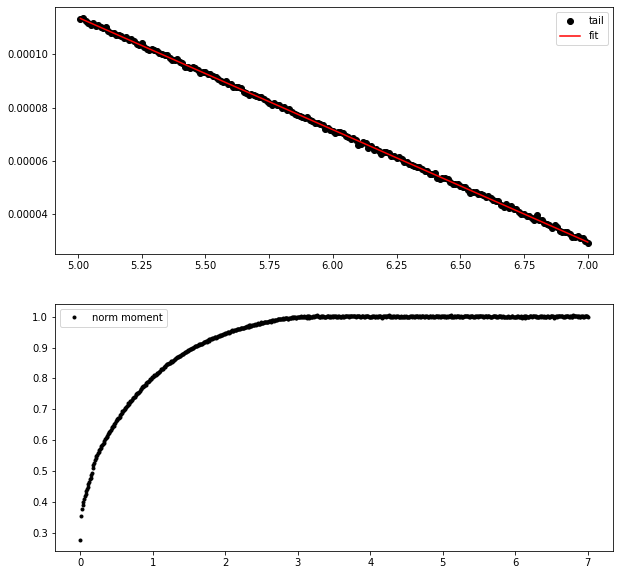

In [4]:
filename = 'J1-7-inplane-295K-N'

#load data and transpose it into columns
field, momentRaw = np.genfromtxt(filename+'-avg.txt', delimiter = '\t', unpack = True)



#extract the last N amount of points
length_of_last_points = 200
tail_x = field[-length_of_last_points:] 
tail_y = momentRaw[-length_of_last_points:]
#fit the tail
a, b = np.polyfit(tail_x, tail_y, 1)



#get some information
moment = momentRaw - field*a
avg_moment = np.mean(moment[-length_of_last_points:])
norm_moment = moment/avg_moment
print(f"a = {a:.2e}\nb = {b:.2e}\navg_moment = {avg_moment:.2e}")

#plot
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

ax1.plot(tail_x, tail_y, 'ko', label="tail")
ax1.plot(tail_x, tail_x*a+b, 'r-', label="fit")
ax2.plot(field, norm_moment, 'k.', label="norm moment")
ax1.legend()
ax2.legend()




# Constants

In [5]:
half_thickness = 4  #thickness of a single ferromagnetic layer in nm
S = 0.2946635385  #surface area of the sample in cm^2
Ms = avg_moment/(2*half_thickness)/S*10**4  #in MA/m to be nice to the solver
print(f'Ms = {Ms*1000} kA/m')
print(f"half thickness = {half_thickness} nm")
print(f"S = {S} cm^2")

Ms = 1375.8349110381441 kA/m
half thickness = 4 nm
S = 0.2946635385 cm^2


# Curve Fit

In [6]:
#initial guesses
J1 = 1
J2 = 1
A = 1

#calculate initial theta_model from J1 and J2
if np.abs(J1)/(2*J2) < 1:
    theta_model_init = 180 - np.arccos(J1/(2*J2))*180/np.pi
else:
    #handle AFC case where |J1|/2J2 >= 1
    theta_model_init = 180

#calculate theta_data from Mr/Ms ratio
MrMs = norm_moment[0]  #not used in solver
theta_data = 2*np.arccos(MrMs)*180/np.pi

print(f"initial model y-int = {np.cos(np.arccos(-J1/(2*J2))/2):.6f}\ndata y-int = {MrMs:.6f}")
print(f"initial model theta = {theta_model_init:.4f} degrees\ndata theta = {theta_data:.4f} degrees")

model y-int = 0.500000
data y-int = 0.280301
model theta = 120.0000 degrees
data theta = 147.4437 degrees


In [7]:
#we need not fit Ms and half_thickness, and since the 'args' in curve_fit seems to not work, lambda is the easiest way
f = lambda H,J1,J2,A: fit_function(H,J1,J2,A,Ms,half_thickness)
#warning: %time hides error message, if pOpt is not defined delete %time and rerun or just remove altogether
%time pOpt, pCov = scipy.optimize.curve_fit(f, field, norm_moment, p0 = [J1,J2,A], bounds = ((0,0,0),(5,5,3)))
y_fit = f(field,*pOpt)
print(f"J1 = {pOpt[0]} mJ/m^2\nJ2 = {pOpt[1]} mJ/m^2\nA = {pOpt[2]} * 10 pJ/m")

Wall time: 1min 45s
J1 = 2.6906504634972364 mJ/m^2
J2 = 1.688881744280407 mJ/m^2
A = 2.999999999997667 * 10 pJ/m


# Results and Residuals

reduced chisq = 6.733 +/- 0.054 

J1 = 2.6907 +/- 0.0037 mJ/m^2
J2 = 1.6889 +/- 0.0038 mJ/m^2
A = 3.0000 +/- 0.0361 * 10 pJ/m

theta from data = 147.4
theta from model = 120.0
average theta = 133.7

measured saturation field = 3.03 T
model saturation field = 2.95 T

Ms = 1375.83 kA/m
Mr = 385.65 kA/m
Mr/Ms = 0.280301



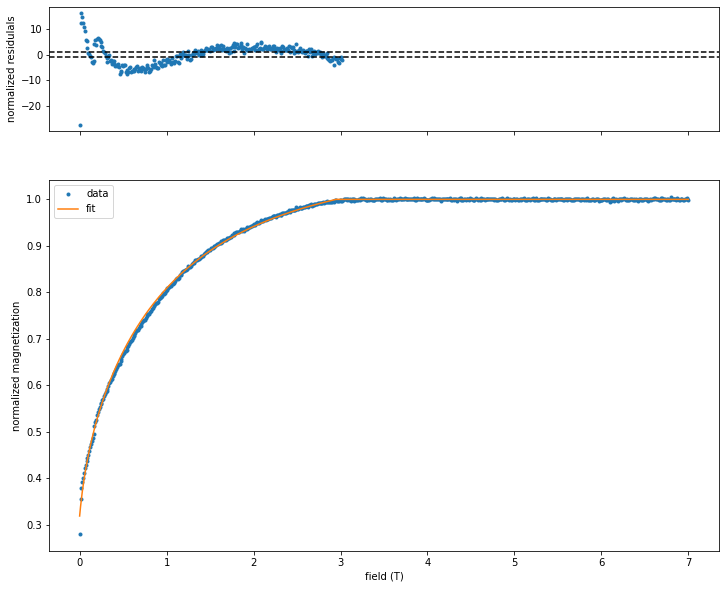

In [8]:
#get reduced chisq and other significant constants

J1, J2, A = pOpt
J1_err, J2_err, A_err = np.sqrt(np.diag(pCov))
#calculate optimal theta_model from J1 and J2
if np.abs(J1)/(2*J2) < 1:
    theta_model = 180 - np.arccos(J1/(2*J2))*180/np.pi
else:
    #handle AFC case where |J1|/2J2 >= 1
    theta_model = 180
theta = np.mean([theta_model, theta_data])
Hsat_model = field[np.where(y_fit==1)[0][0]]
Hsat_data = field[np.where(np.isclose(norm_moment, 1, rtol=0.001))[0][0]]
Hsat_i = np.where(np.isclose(norm_moment, 1, rtol=0.001))[0][0]

#calculate residuals
res = (norm_moment[:Hsat_i] - y_fit[:Hsat_i])
empty_res = np.zeros(len(norm_moment[Hsat_i:]))
empty_res[:] = np.nan
#calculate chisq from the standard deviation of the tail
sigma = np.std(norm_moment[-length_of_last_points:])
norm_res = res/sigma
chisq_red = np.sum(norm_res**2)/Hsat_i


print(f"reduced chisq = {chisq_red:.3f} +/- {np.sqrt(2/(len(field)-len(pOpt))):.3f} \n")

print(f"J1 = {J1:.4f} +/- {J1_err:.4f} mJ/m^2\nJ2 = {J2:.4f} +/- {J2_err:.4f} mJ/m^2\nA = {A:.4f} +/- {A_err:.4f} * 10 pJ/m\n")

print(f"theta from data = {theta_data:.1f}\ntheta from model = {theta_model:.1f}\naverage theta = {theta:.1f}\n")

print(f"measured saturation field = {Hsat_data:.2f} T")
print(f"model saturation field = {Hsat_model:.2f} T\n")


print(f"Ms = {Ms*1000:.2f} kA/m\nMr = {MrMs*Ms*1000:.2f} kA/m\nMr/Ms = {MrMs:.6f}\n")




# make plots
fig, (ax1,ax2) = plt.subplots(2,1, figsize = (12,10), gridspec_kw = {'height_ratios': (1,3)}, sharex = True)

ax1.plot(field[:Hsat_i], norm_res, '.')
ax1.axhline(y = 1, linestyle = '--', color = 'k')
ax1.axhline(y = -1, linestyle = '--', color = 'k')
ax1.set(ylabel = 'normalized residulals')

ax2.plot(field, norm_moment, '.', label = 'data')
ax2.plot(field, y_fit, label = 'fit')
ax2.set(ylabel = 'normalized magnetization', xlabel="field (T)")
ax2.legend()



#plt.savefig(filename+'-fit.png',bbox_inches='tight')


# Saving

In [9]:

header = f'''ran on: {date.today()}
method = continuous (https://github.com/Elliot-Wadge/MagnetizationFitting)
Ms = {Ms*1000:.2f} kA/m
Mr/Ms = {MrMs:.4f}
J1 = {J1:.4f} +/- {J1_err:.4f} mJ/m^2
J2 = {J2:.4f} +/- {J2_err:.4f} mJ/m^2
A = {A:.4f} +/- {A_err:.4f} * 10 pJ/m
theta from data = {theta_data:.2f} degrees
theta from model = {theta_model:.2f} degrees
average theta = {theta:.2f} degrees
measured saturation field = {Hsat_data:.3f} T
model saturation field = {Hsat_model:.3f} T
red chisq = {chisq_red:.3f} +/- {np.sqrt(2/(len(field)-len(pOpt))):.3f}
standard deviation = {sigma:.6f}

Field (T),Mag (Data) (kA/m),Mag (Model) (kA/m),Residuals(kA/m)'''
print(header)

ran on: 2022-08-08
method = continuous (https://github.com/Elliot-Wadge/MagnetizationFitting)
Ms = 1375.83 kA/m
Mr/Ms = 0.2803
J1 = 2.6907 +/- 0.0037 mJ/m^2
J2 = 1.6889 +/- 0.0038 mJ/m^2
A = 3.0000 +/- 0.0361 * 10 pJ/m
theta from data = 147.44 degrees
theta from model = 120.00 degrees
average theta = 133.72 degrees
measured saturation field = 3.030 T
model saturation field = 2.950 T
red chisq = 6.733 +/- 0.054
standard deviation = 0.001411

Field (T),Mag (Data) (kA/m),Mag (Model) (kA/m),Residuals(kA/m)


In [10]:
outname = filename + '-fit.csv'
print(f"saved to {outname}")
save = np.vstack((field, norm_moment*Ms, np.array(y_fit)*Ms, np.concatenate((res*Ms,empty_res))))
np.savetxt(outname, save.T, delimiter=',', header=header)

saved to J1-7-inplane-295K-N-fit.csv


[[ 0.          0.01        0.02       ...  6.98        6.99
   7.        ]
 [ 0.38564748  0.48971558  0.52039064 ...  1.378689    1.37597854
   1.37420134]
 [ 0.438784    0.46555697  0.48887094 ...  1.37583491  1.37583491
   1.37583491]
 [-0.05313652  0.0241586   0.0315197  ...         nan         nan
          nan]]


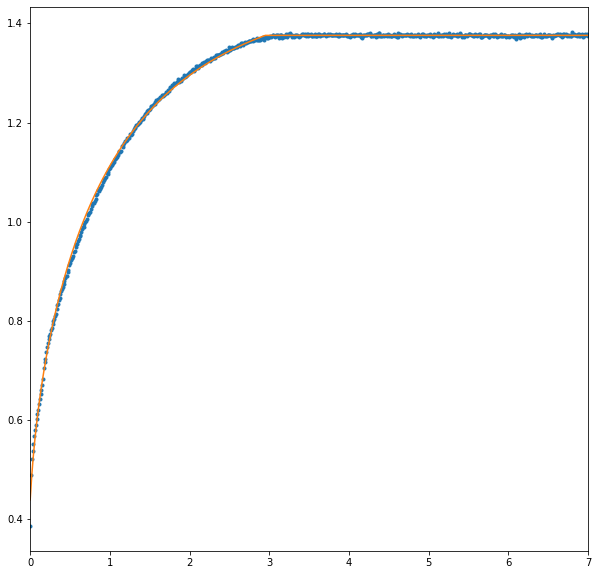

In [11]:
file_out = np.genfromtxt(outname, delimiter = ',').T

print(file_out)

fig = plt.figure(figsize = (10,10))
plt.plot(file_out[0],file_out[1],'.')
plt.plot(file_out[0],file_out[2])

#plt.plot(file[2],file[3])

plt.xlim(0,7)

plt.show()